In [1]:
import numpy as np
import scipy.optimize as sp
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
import juliandate as jd

In [2]:
df = pd.read_csv('Master_Data.csv')

Text(0, 0.5, 'Flux')

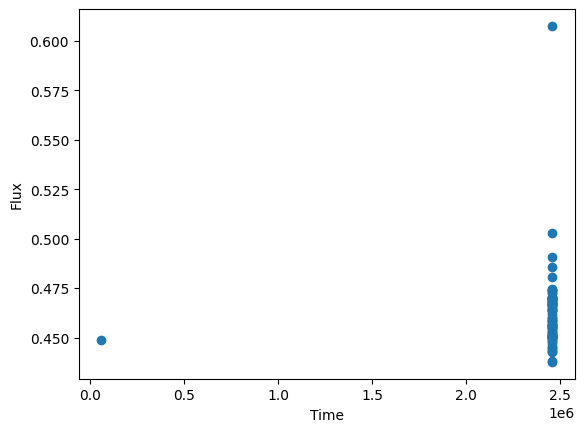

In [3]:
time = df['JD_UTC']
flux = df['av_rel_flux T1']
error = df['std_T1']

plt.scatter(time, flux)
#plt.xlim(2.45e6,2.46e6)
plt.xlabel('Time')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

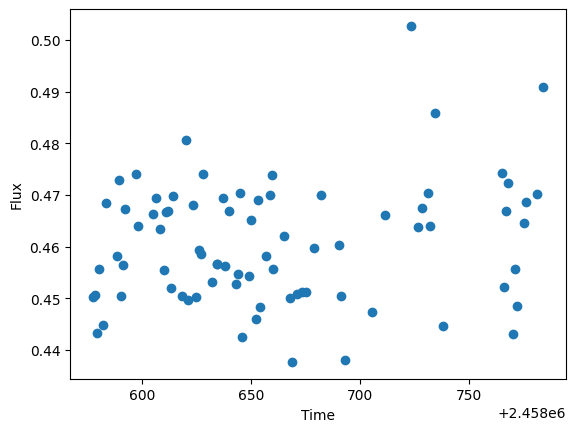

In [4]:
# CLEANED DATA SET

dropped = df.drop([30,63]) # use this one
dropped.where(df['JD_UTC'] < 2.4e6).dropna()

d_time = dropped['JD_UTC'] # time
d_flux = dropped['av_rel_flux T1'] # signal
d_error = dropped['std_T1']
plt.scatter(d_time, d_flux)
plt.xlabel('Time')
plt.ylabel('Flux')


In [5]:
# ROBERT QUIMBY VIDEO - MANUAL METHOD
# frequency is 1/period -> plot period instead of frequency


t_man = dropped['JD_UTC'] 
flux_man = dropped['av_rel_flux T1'] - np.mean(dropped['av_rel_flux T1'])
error_man = dropped['std_T1']

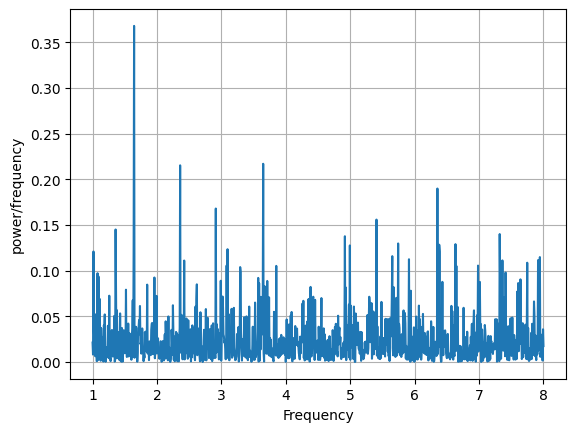

In [6]:
def get_model(params, freq, times):
    A, phi = params
    return A * np.cos(2 * np.pi * freq * times + phi)

def get_chisq(params, times, freq, values):
    model = get_model(params, freq, times)
    return np.sum((values - model)**2)
    
freqs = np.linspace(1, 8, 1000)
Y = np.matrix([[value] for value in flux_man])
A2, chisq = [], []

for freq in freqs:
    thetas = 2 * np.pi * freq * t_man
    X = np.matrix([[np.cos(theta), np.sin(theta)]for theta in thetas])
    p = (X.T * X).I * (X.T * Y)
    B, C = p.A1
    A = B/np.abs(B) * np.hypot(B,C)
    A2.append(A**2)
    phi = np.arctan(-C/B)
    chisq.append(get_chisq((A, phi), t_man, freq, flux_man))
chisq = np.array(chisq)
A2 = np.array(A2)
chisq0 = np.sum((flux_man - np.mean(flux_man))**2)
P = (chisq0 - chisq)/chisq0

plt.plot(freqs, P)
plt.xlabel("Frequency")
plt.ylabel("power/frequency")
plt.grid();

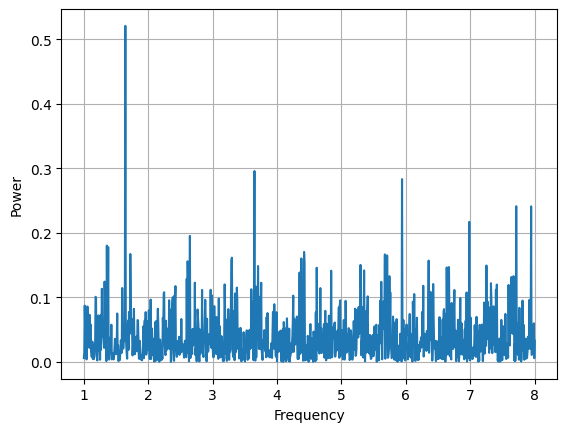

In [7]:
# ROBERT QUIMBY VIDEO - ASTROPY METHOD

t_astro = dropped['JD_UTC'] * u.day
mags = dropped['av_rel_flux T1'] - np.mean(dropped['av_rel_flux T1']) * u.mag
ls = LombScargle(t_astro, mags, d_error)
freqs = np.linspace(1, 8, 1000)
power = ls.power(freqs)

plt.plot(freqs, power)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid();

In [8]:
max_power = power[power == max(power)]
max_power_index = np.where(power == max_power)[0]
best_fit_period = freqs[max_power_index]
print(best_fit_period)

[1.64464464]


In [9]:
ls.false_alarm_probability(power.max())

8.890672170607433e-10

In [10]:
ls.model_parameters(5.601)

array([-7.53371234e-05, -1.95411304e-03, -2.94314743e-04])

In [11]:
ls.model(t_astro, 5.601)

array([-5.88117670e-04, -2.78735950e-03, -2.43267950e-03, -1.85849724e-03,
       -2.57039225e-03, -2.76641602e-03,  1.15837723e-03, -8.15855025e-04,
        1.15884230e-03, -2.78617358e-03,  1.13489794e-03, -2.10437210e-03,
       -7.47901109e-04, -4.00457772e-04, -2.60129529e-03,  1.12699733e-03,
       -1.99203668e-03, -2.68336755e-03, -1.01982441e-03,  1.15555419e-03,
       -2.04136728e-03,  1.33023651e-04, -4.94353804e-04, -2.58287160e-03,
        1.13088625e-03, -5.55751890e-04, -2.70094907e-03, -2.76231893e-03,
        9.55934724e-04, -1.40659968e-03, -1.24850911e-03, -5.88117670e-04,
        9.91602071e-04, -1.80179660e-03,  5.26411388e-04, -1.86779913e-03,
       -1.10152463e-03,  5.71267645e-04, -2.76892599e-03, -1.23105518e-03,
        6.61786699e-04, -1.12505884e-03, -1.57240030e-03, -1.29154648e-03,
        8.40758954e-04, -2.44081099e-03,  8.46391374e-04,  1.15320953e-03,
        1.14748147e-03, -1.95672170e-03, -1.06455285e-03, -2.69505353e-03,
        9.64509750e-04,  

In [12]:
ls, power = LombScargle(t_astro, mags, d_error).autopower()

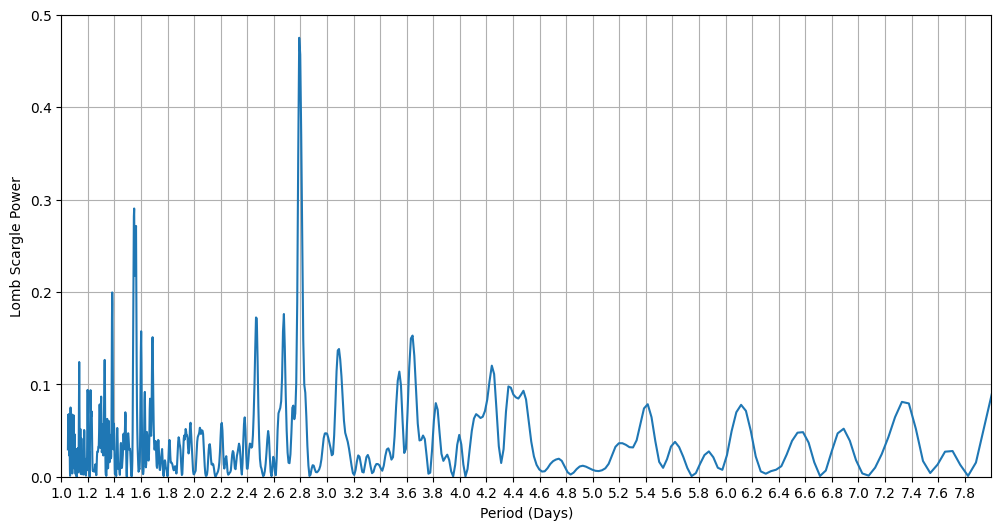

In [24]:
plt.figure(figsize = (12, 6))

t_end = 8

plt.xlim(1, t_end)
plt.ylim(0, 0.5)
plt.plot(1/ls, power)
plt.xticks(np.arange(1, t_end, 0.2))

plt.xlabel("Period (Days)")
plt.ylabel("Lomb Scargle Power")
plt.grid()

In [29]:
period = 1/ls